In [202]:
""" 
Importieren von wichtigen Plugins für das System:
- Pandas zur Nutzung von Dataframes als Datentyp zur Speicherung, Veränderung und Anzeige des Datensatzes
- Surprise zur Einbindung als Framework für das Vorschlagssystem inklusive der Algorithmen und Auswertungen
- Der Rest für die Erleichterung der Darstellung und mathematischer Umformungen
"""
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
from surprise import Reader, Dataset, SVD, accuracy
sns.set_style("darkgrid")
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from statsmodels.stats.outliers_influence import summary_table

In [203]:
"""
Der erste Teil:
- Datensatz importieren: hier Movielens 100k aufgrund der Größe und Uploadbarkeit für GitHub
- Datensatz auf gewünschtes Format bringen: Matrix
"""

'\nDer erste Teil:\n- Datensatz importieren: hier Movielens 100k aufgrund der Größe und Uploadbarkeit für GitHub\n- Datensatz auf gewünschtes Format bringen: Matrix\n'

In [204]:
"""
Importieren vom Datensatz:
Jeder Eintrag besteht aus: einem User (mit ID), der einem Film (mit ID), ein Rating auf einer Skala von 1-5 (als Float) gibt
"""
ratings = pd.read_csv('ratings100k.csv')
print(ratings.head())  #Anzeige des Kopfes vom Dataframe zur Veranschaulichung

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [205]:
"""
Umformung in ein für Surprise nutzbares Format: 
Cust_Id - Rating - Movie_Id
Timestamp wird nicht benötigt
"""
ratings = ratings.rename(columns={"userId": "Cust_Id", "rating": "Rating", "movieId": "Movie_Id"})
ratings = ratings.drop(['timestamp'], axis=1)
ratings = ratings[['Cust_Id','Rating','Movie_Id']]
print(ratings.head())

   Cust_Id  Rating  Movie_Id
0        1     4.0         1
1        1     4.0         3
2        1     4.0         6
3        1     5.0        47
4        1     5.0        50


In [206]:
"""
Um etwas Zugriff zu bekommen, werden User und Filme rausgeschmissen, die zu wenig Bewertungen bekommen.
Inhaltlich passt dies auch, da diese Nutzer zuerst auf anderem Wege (Cold Start) Vorschläge erhalten
"""
f = ['count','mean']

df_movie_summary = ratings.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = ratings.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 7.0
Customer minimum times of review: 140.0


In [207]:
#Umformung vom Datensatz in eine Matrix (Für die Nutzbarkeit)
rating_matrix = pd.pivot_table(ratings,values='Rating',index='Cust_Id',columns='Movie_Id')

rating_matrix

Movie_Id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
Cust_Id,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
"""
Eine Funktion, die mit Hilfe der SVD Matrix Faktorisierung für Nutzer im 75/25 Verhältnis Filmbewertungen vorhersagt.
Dabei werden 75% vorhandener Daten zum Trainieren benutzt, um 25% der Testdaten vorherzusagen
"""
def VorhersagenErzeugen():
    #Aufteilen des Datensatzes in Trainings- und Testdaten (75 zu 25 Prozent)
    reader = Reader()
    data = Dataset.load_from_df(ratings[['Cust_Id', 'Movie_Id', 'Rating']], reader)
    trainset, testset = train_test_split(data, test_size=.25)

    #Anwenden des SVD Algorithmus, um Ratings im Testset vorherzusagen 
    algo = SVD()
    algo.fit(trainset)
    predictions = algo.test(testset)
    vorhersagen = pd.DataFrame(predictions)
    vorhersagen = vorhersagen.drop(['details'], axis=1)
    vorhersagen['diff'] = np.abs(vorhersagen['r_ui'] - vorhersagen['est'])
    vorhersagen['Erlös'] = np.where(vorhersagen['est'] > 3.4 , 5, 0)
    return vorhersagen

In [209]:
# 5 verschiedene Datensätze mit Vorhersagen erstellen
vorhersagen1 = VorhersagenErzeugen()
vorhersagen2 = VorhersagenErzeugen()
vorhersagen3 = VorhersagenErzeugen()
vorhersagen4 = VorhersagenErzeugen()
vorhersagen5 = VorhersagenErzeugen()

In [210]:
# So sieht einer der Datensätze aus 
vorhersagen1.head()

,uid,iid,r_ui,est,diff,Erlös
0,304,172,2.0,3.567185,1.567185,5
1,474,5525,3.5,3.336526,0.163474,0
2,479,973,4.0,3.381598,0.618402,0
3,517,88744,0.5,2.568466,2.068466,0
4,64,2396,4.0,3.805223,0.194777,5


In [211]:
"""
In dieser Hilfsfunktion kann einem Datensatz eine neue Spalte mit Kosten hinzugefügt werden. Dabei kann ebenfalls ein
Modus der Verteilungsart angegeben werden. Bisher, bis ein überzeugendes Konzept erstellt wird, sind diese Modi
allesamt nach Zufallsverteilungen bestimmt.

Profit Linear bezieht sich darauf, dass die User so viel Ertrag einspielen, wie sie den Film finden
Profit Cutoff bezieht sich darauf, dass die User ab einer Bewertung von 3,4 gleich viel Geld einspielen und darunter nichts
"""
def KostenErstellen(datensatz, modus):
    #Anzahl Filme feststellen
    vorhersagen_filme = datensatz['iid'].sort_values(ascending=True).drop_duplicates()
    vorhersagen_filme = vorhersagen_filme.reset_index(drop=True)
    #Kosten hinzugeben
    kosten = pd.DataFrame(modus)
    kosten = kosten.rename(columns={0:'Kosten'})
    kosten = pd.concat([vorhersagen_filme, kosten], axis = 1)
    kosten = kosten.set_index('iid')
    vorhersagenMitKosten = pd.merge(datensatz, kosten, on='iid')
    #Spalten mit Profit für jeden Film für jeden User anfügen
    vorhersagenMitKosten['ProfitLinear'] = vorhersagenMitKosten['est'] - vorhersagenMitKosten['Kosten']
    vorhersagenMitKosten['ProfitCutoff'] = vorhersagenMitKosten['Erlös'] - vorhersagenMitKosten['Kosten']
    vorhersagenMitKosten['ProfitTatsächlich'] = vorhersagenMitKosten['r_ui'] - vorhersagenMitKosten['Kosten']
    return vorhersagenMitKosten

In [212]:
# Die Datensätze anreichern
vorhersagenMitKosten1 = KostenErstellen(vorhersagen1, np.random.uniform(0.5, 5.0, size = vorhersagen1.iid.drop_duplicates().size))
vorhersagenMitKosten2 = KostenErstellen(vorhersagen2, np.random.randint(0, 5, size = vorhersagen2.iid.drop_duplicates().size))
vorhersagenMitKosten3 = KostenErstellen(vorhersagen3, np.random.triangular(0, 3, 5, size = vorhersagen3.iid.drop_duplicates().size))
vorhersagenMitKosten4 = KostenErstellen(vorhersagen4, np.random.wald(3, 2.5, size = vorhersagen4.iid.drop_duplicates().size))
vorhersagenMitKosten5 = KostenErstellen(vorhersagen5, np.random.randint(0, 3, size = vorhersagen5.iid.drop_duplicates().size))

In [213]:
# Das erste DataFrame als Beispiel
vorhersagenMitKosten1.head(5)

,uid,iid,r_ui,est,diff,Erlös,Kosten,ProfitLinear,ProfitCutoff,ProfitTatsächlich
0,304,172,2.0,3.567185,1.567185,5,3.648716,-0.081531,1.351284,-1.648716
1,489,172,0.5,2.419998,1.919998,0,3.648716,-1.228717,-3.648716,-3.148716
2,313,172,1.0,3.029389,2.029389,0,3.648716,-0.619327,-3.648716,-2.648716
3,483,172,3.5,3.038185,0.461815,0,3.648716,-0.610531,-3.648716,-0.148716
4,602,172,3.0,2.761808,0.238192,0,3.648716,-0.886908,-3.648716,-0.648716


In [214]:
"""
Jetzt kommen Hilfsfunktionen, bei denen Nutzer jeweils X Filmvorschläge bekommen. Dabei bin ich so vorgegangen, 
dass ich zuerst eine Funktion für einzelne User erstellt habe, diese auf alle User angewandt, aber noch nicht den
Modus spezifiziert habe und in der Folge einzelne Funktionen für verschiedene Modi für alle User erstellt habe
"""

'\nJetzt kommen Hilfsfunktionen, bei denen Nutzer jeweils X Filmvorschläge bekommen. Dabei bin ich so vorgegangen, \ndass ich zuerst eine Funktion für einzelne User erstellt habe, diese auf alle User angewandt, aber noch nicht den\nModus spezifiziert habe und in der Folge einzelne Funktionen für verschiedene Modi für alle User erstellt habe\n'

In [215]:
#Leere Listen für die Ergebnisse
liste_empfehlungen_nutzen = []
liste_topratings_nutzen = []
liste_quotienten_nutzen = []

liste_empfehlungen_profit = []
liste_topratings_profit = []
liste_quotienten_profit = []

liste_empfehlungen_profit_cutoff = []
liste_topratings_profit_cutoff = []
liste_quotienten_profit_cutoff = []
amount = 8
#amount = 10

In [216]:
"""
Für den Nutzer werden einzelne Vorhersagen getroffen und in der Folge:
-die Summe der Bewertungen der X vorgeschlagenen Filme in dem Modus
-die Summe der Bewertungen der X bestmöglichen Filme für den Nutzer
-das Verhältnis aus diesen beiden Werten, um die Güte der Bewertung quantifizieren zu können
"""
def optimierungsingleuser(user, datensatz, modus, liste_e, liste_t, liste_q):    
    vorhersagen_nutzer = datensatz[datensatz['uid'] == user]
    topx_vorhersagen = vorhersagen_nutzer.sort_values(modus, ascending=False).head(amount)
    topx_ratings = vorhersagen_nutzer.sort_values('r_ui', ascending=False).head(amount)
    summe_empfehlungen = np.sum(topx_vorhersagen['r_ui'])
    summe_ratings = np.sum(topx_ratings['r_ui'])
    quotient = summe_empfehlungen / summe_ratings
    liste_e.append(summe_empfehlungen)
    liste_t.append(summe_ratings)
    liste_q.append(quotient)

In [217]:

def optimierungalleuser(modus, datensatz, liste_e, liste_t, liste_q):
    #Anwendung auf alle Nutzer
    for i in range(1,610):
        optimierungsingleuser(i, datensatz, modus, liste_e, liste_t, liste_q)
    #Erstellung von einem DataFrame für die Ausgaben für alle Nutzer zum Sammeln
    e_series = pd.Series(liste_e)
    t_series = pd.Series(liste_t)
    q_series = pd.Series(liste_q)
    etq_df = pd.concat([e_series, t_series, q_series], axis = 1)
    etq_df = etq_df.rename(columns={0:'Top X', 1:'Max X', 2:'Quote' })
    etq_df['Nutzer'] = etq_df.index + 1
    #Durchschnitte aller Spalten berechnen
    q_avg = np.mean(etq_df['Quote'])
    t_avg = np.mean(etq_df['Max X'])
    e_avg = np.mean(etq_df['Top X'])
    print('durchschnittliches Rating der Empfehlungen beträgt: '+  str(e_avg))
    print('durchschnittliches Rating der Top X für den User beträgt: '+ str(t_avg))
    print('durchschnittlicher Quotient für den User beträgt: '+ str(q_avg))
    return etq_df, q_avg

In [218]:
#einzelne Funktion für Nutzenoptimierung
def nutzenoptimierungalleuser(datensatz):
    UebersichtNutzen, durchschnittlicherNutzen = optimierungalleuser('est', datensatz, liste_empfehlungen_nutzen, liste_topratings_nutzen, liste_quotienten_nutzen)
    return UebersichtNutzen, durchschnittlicherNutzen
    

In [219]:
#einzelne Funktion für Profitoptimierung
def profitoptimierungalleuser(datensatz):
    UebersichtProfit, durchschnittlicherNutzenProfit = optimierungalleuser('ProfitLinear', datensatz, liste_empfehlungen_profit, liste_topratings_profit, liste_quotienten_profit)
    return UebersichtProfit, durchschnittlicherNutzenProfit

In [220]:
#einzelne Funktion für Profitoptimierung
def profitoptimierungalleuserCutoff(datensatz):
    UebersichtProfitCutoff, durchschnittlicherNutzenProfitCutoff = optimierungalleuser('ProfitCutoff', datensatz, liste_empfehlungen_profit_cutoff, liste_topratings_profit_cutoff, liste_quotienten_profit_cutoff)
    return UebersichtProfitCutoff, durchschnittlicherNutzenProfitCutoff

In [221]:
"""
Nun kommt die Auswertungsphase, in der mit:
-Profitoptimierung Linear
-Profitoptimierung mit Cutoff
-Nutzenoptimierung
Vorschläge gemacht werden und für die Gesamtheit aller Nutzer ausgerechnet, wie die Güte der Ergebnisse ist
"""

'\nNun kommt die Auswertungsphase, in der mit:\n-Profitoptimierung Linear\n-Profitoptimierung mit Cutoff\n-Nutzenoptimierung\nVorschläge gemacht werden und für die Gesamtheit aller Nutzer ausgerechnet, wie die Güte der Ergebnisse ist\n'

In [222]:
#Für alle 5 Datensätze profitoptimierende Vorschläge geben
UebersichtProfit1, durchschnittlicherNutzenProfit1 = profitoptimierungalleuser(vorhersagenMitKosten1)
UebersichtProfit2, durchschnittlicherNutzenProfit2 = profitoptimierungalleuser(vorhersagenMitKosten2)
UebersichtProfit3, durchschnittlicherNutzenProfit3 = profitoptimierungalleuser(vorhersagenMitKosten3)
UebersichtProfit4, durchschnittlicherNutzenProfit4 = profitoptimierungalleuser(vorhersagenMitKosten4)
UebersichtProfit5, durchschnittlicherNutzenProfit5 = profitoptimierungalleuser(vorhersagenMitKosten5)

durchschnittliches Rating der Empfehlungen beträgt: 28.39737274220033
durchschnittliches Rating der Top X für den User beträgt: 32.889162561576356
durchschnittlicher Quotient für den User beträgt: 0.877225543529411
durchschnittliches Rating der Empfehlungen beträgt: 28.36863711001642
durchschnittliches Rating der Top X für den User beträgt: 32.89203612479474
durchschnittlicher Quotient für den User beträgt: 0.876799215353742
durchschnittliches Rating der Empfehlungen beträgt: 28.366174055829227
durchschnittliches Rating der Top X für den User beträgt: 32.8639846743295
durchschnittlicher Quotient für den User beträgt: 0.8775801206258254
durchschnittliches Rating der Empfehlungen beträgt: 28.33353858784893
durchschnittliches Rating der Top X für den User beträgt: 32.88628899835796
durchschnittlicher Quotient für den User beträgt: 0.8761923149270813
durchschnittliches Rating der Empfehlungen beträgt: 28.33399014778325
durchschnittliches Rating der Top X für den User beträgt: 32.8650246305

In [223]:
#Für alle 5 Datensätze profitoptimierende Vorschläge geben
UebersichtProfitCutoff1, durchschnittlicherNutzenProfitCutoff1 = profitoptimierungalleuserCutoff(vorhersagenMitKosten1)
UebersichtProfitCutoff2, durchschnittlicherNutzenProfitCutoff2 = profitoptimierungalleuserCutoff(vorhersagenMitKosten2)
UebersichtProfitCutoff3, durchschnittlicherNutzenProfitCutoff3 = profitoptimierungalleuserCutoff(vorhersagenMitKosten3)
UebersichtProfitCutoff4, durchschnittlicherNutzenProfitCutoff4 = profitoptimierungalleuserCutoff(vorhersagenMitKosten4)
UebersichtProfitCutoff5, durchschnittlicherNutzenProfitCutoff5 = profitoptimierungalleuserCutoff(vorhersagenMitKosten5)

durchschnittliches Rating der Empfehlungen beträgt: 28.3752052545156
durchschnittliches Rating der Top X für den User beträgt: 32.889162561576356
durchschnittlicher Quotient für den User beträgt: 0.8774565781957292
durchschnittliches Rating der Empfehlungen beträgt: 28.36904761904762
durchschnittliches Rating der Top X für den User beträgt: 32.89203612479474
durchschnittlicher Quotient für den User beträgt: 0.8776718844061925
durchschnittliches Rating der Empfehlungen beträgt: 28.37110016420361
durchschnittliches Rating der Top X für den User beträgt: 32.8639846743295
durchschnittlicher Quotient für den User beträgt: 0.8784483895726449
durchschnittliches Rating der Empfehlungen beträgt: 28.330254515599343
durchschnittliches Rating der Top X für den User beträgt: 32.88628899835796
durchschnittlicher Quotient für den User beträgt: 0.8768633756854298
durchschnittliches Rating der Empfehlungen beträgt: 28.3128078817734
durchschnittliches Rating der Top X für den User beträgt: 32.8650246305

In [224]:
#Für alle 5 Datensätze allen Nutzern nutzenoptimierende (baseline) Vorschläge
UebersichtNutzen1, durchschnittlicherNutzen1 = nutzenoptimierungalleuser(vorhersagenMitKosten1)
UebersichtNutzen2, durchschnittlicherNutzen2 = nutzenoptimierungalleuser(vorhersagenMitKosten2)
UebersichtNutzen3, durchschnittlicherNutzen3 = nutzenoptimierungalleuser(vorhersagenMitKosten3)
UebersichtNutzen4, durchschnittlicherNutzen4 = nutzenoptimierungalleuser(vorhersagenMitKosten4)
UebersichtNutzen5, durchschnittlicherNutzen5 = nutzenoptimierungalleuser(vorhersagenMitKosten5)


durchschnittliches Rating der Empfehlungen beträgt: 29.37192118226601
durchschnittliches Rating der Top X für den User beträgt: 32.889162561576356
durchschnittlicher Quotient für den User beträgt: 0.9045591381404335
durchschnittliches Rating der Empfehlungen beträgt: 29.42241379310345
durchschnittliches Rating der Top X für den User beträgt: 32.89203612479474
durchschnittlicher Quotient für den User beträgt: 0.9058560955323423
durchschnittliches Rating der Empfehlungen beträgt: 29.399014778325125
durchschnittliches Rating der Top X für den User beträgt: 32.8639846743295
durchschnittlicher Quotient für den User beträgt: 0.9058962231365664
durchschnittliches Rating der Empfehlungen beträgt: 29.4068144499179
durchschnittliches Rating der Top X für den User beträgt: 32.88628899835796
durchschnittlicher Quotient für den User beträgt: 0.9055814333959119
durchschnittliches Rating der Empfehlungen beträgt: 29.401806239737276
durchschnittliches Rating der Top X für den User beträgt: 32.86502463

In [225]:
UebersichtProfitCutoff1

,Top X,Max X,Quote,Nutzer
0,38.0,40.0,0.950000,1
1,30.5,33.0,0.924242,2
2,8.0,14.5,0.551724,3
3,32.0,40.0,0.800000,4
4,31.0,33.0,0.939394,5
...,...,...,...,...
604,25.5,37.5,0.680000,605
605,30.5,40.0,0.762500,606
606,31.0,40.0,0.775000,607
607,32.0,40.0,0.800000,608


In [226]:
#Ausrechnen inwiefern die Ergebnisse durch den Modus schwächer als die Baseline sind
NutzenUnterschied1 = (1 - (durchschnittlicherNutzenProfit1 / durchschnittlicherNutzen1)) * 100
print('Profitorientiert liefert ' + str(NutzenUnterschied1) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied2 = (1 - (durchschnittlicherNutzenProfit2 / durchschnittlicherNutzen2)) * 100
print('Profitorientiert liefert ' + str(NutzenUnterschied2) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied3 = (1 - (durchschnittlicherNutzenProfit3 / durchschnittlicherNutzen3)) * 100
print('Profitorientiert liefert ' + str(NutzenUnterschied3) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied4 = (1 - (durchschnittlicherNutzenProfit4 / durchschnittlicherNutzen4)) * 100
print('Profitorientiert liefert ' + str(NutzenUnterschied4) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied5 = (1 - (durchschnittlicherNutzenProfit5 / durchschnittlicherNutzen5)) * 100
print('Profitorientiert liefert ' + str(NutzenUnterschied5) + ' ' +'%' + ' schwächere Ergebnisse')

Profitorientiert liefert 3.0217587174249494 % schwächere Ergebnisse
Profitorientiert liefert 3.207670657834949 % schwächere Ergebnisse
Profitorientiert liefert 3.125755664672014 % schwächere Ergebnisse
Profitorientiert liefert 3.2453313843485154 % schwächere Ergebnisse
Profitorientiert liefert 3.2226506321926918 % schwächere Ergebnisse


In [227]:
#Ausrechnen inwiefern die Ergebnisse durch den Modus schwächer als die Baseline sind
NutzenUnterschied1 = (1 - (durchschnittlicherNutzenProfitCutoff1 / durchschnittlicherNutzen1)) * 100
print('Profitorientiert mit Cutoff liefert ' + str(NutzenUnterschied1) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied2 = (1 - (durchschnittlicherNutzenProfitCutoff2 / durchschnittlicherNutzen2)) * 100
print('Profitorientiert mit Cutoff liefert ' + str(NutzenUnterschied2) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied3 = (1 - (durchschnittlicherNutzenProfitCutoff3 / durchschnittlicherNutzen3)) * 100
print('Profitorientiert mit Cutoff liefert ' + str(NutzenUnterschied3) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied4 = (1 - (durchschnittlicherNutzenProfitCutoff4 / durchschnittlicherNutzen4)) * 100
print('Profitorientiert mit Cutoff liefert ' + str(NutzenUnterschied4) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschied5 = (1 - (durchschnittlicherNutzenProfitCutoff5 / durchschnittlicherNutzen5)) * 100
print('Profitorientiert mit Cutoff liefert ' + str(NutzenUnterschied5) + ' ' +'%' + ' schwächere Ergebnisse')

Profitorientiert mit Cutoff liefert 2.9962175829013282 % schwächere Ergebnisse
Profitorientiert mit Cutoff liefert 3.111334268782151 % schwächere Ergebnisse
Profitorientiert mit Cutoff liefert 3.029909261447883 % schwächere Ergebnisse
Profitorientiert mit Cutoff liefert 3.1712286329446893 % schwächere Ergebnisse
Profitorientiert mit Cutoff liefert 3.203966099300981 % schwächere Ergebnisse


In [228]:
#Hilfsmethode, um bei einzelnen Nutzern in die Vorschläge einzusehen
def nutzercheck(user, modus, datensatz):
    nutzerVorschläge = datensatz[datensatz['uid'] == user].sort_values(modus, ascending=False).head(amount)
    return nutzerVorschläge

In [229]:
#die Funktion zur Veranschaulichung angewendet
nutzerframe = nutzercheck(5, 'ProfitLinear', vorhersagenMitKosten1)
nutzerframe

,uid,iid,r_ui,est,diff,Erlös,Kosten,ProfitLinear,ProfitCutoff,ProfitTatsächlich
13771,5,290,5.0,3.585784,1.414216,5,0.539235,3.046549,4.460765,4.460765
13485,5,261,4.0,3.667383,0.332617,5,0.982397,2.684986,4.017603,3.017603
4100,5,597,3.0,3.373762,0.373762,0,1.282503,2.091259,-1.282503,1.717497
7915,5,608,3.0,4.239684,1.239684,5,2.384742,1.854943,2.615258,0.615258
3006,5,318,3.0,4.134011,1.134011,5,2.460362,1.673649,2.539638,0.539638
15379,5,349,3.0,3.560962,0.560962,5,1.911821,1.649140,3.088179,1.088179
13263,5,380,2.0,3.250037,1.250037,0,2.310820,0.939217,-2.310820,-0.310820
986,5,590,5.0,3.880009,1.119991,5,3.292002,0.588007,1.707998,1.707998


In [230]:
"""
Noch ein paar Graphen als Bonus
"""

'\nNoch ein paar Graphen als Bonus\n'

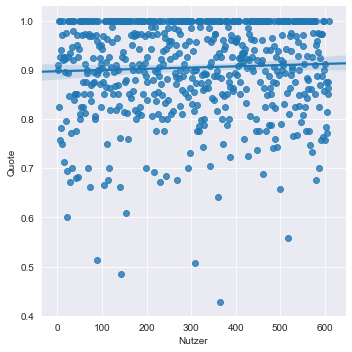

In [231]:
sns.lmplot(data=UebersichtNutzen1, x="Nutzer", y='Quote')

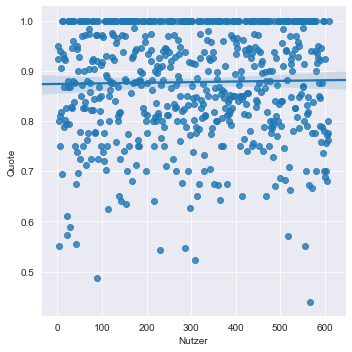

In [232]:
sns.lmplot(data=UebersichtProfitCutoff1, x="Nutzer", y='Quote')

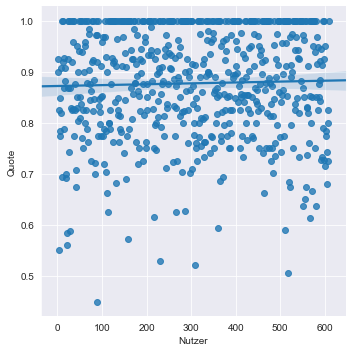

In [233]:
sns.lmplot(data=UebersichtProfit1, x="Nutzer", y='Quote')